In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("DynamicalSystems")
Pkg.add("Distributions")
Pkg.add("MathOptInterface")
Pkg.add("Ipopt")
Pkg.add("FiniteDiff")
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
import Convex as cvx 
import ECOS
using JLD2
using Test
using Random
using ProgressMeter
import MathOptInterface as MOI
import Ipopt 
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))
using GaussianFilters, LinearAlgebra, Distributions
include(joinpath(@__DIR__,"utils/rendezvous.jl"))
Pkg.add("SymPy")
using SymPy

  Activating environment at `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal

In [5]:
# utilities for converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function dynamics(params::NamedTuple, x::Vector, u)
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    nx, nu = size(B)
    dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    Ad = dt_mat[1:nx, 1:nx]
    Bd = dt_mat[1:nx, (nx+1):end]

    return Ad, Bd

end

function create_dynamics(dt::Real)::Tuple{Matrix,Matrix}
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    nx, nu = size(B)
    dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    Ad = dt_mat[1:nx, 1:nx]
    Bd = dt_mat[1:nx, (nx+1):end]

    return Ad, Bd
end

function process_model(x, u, dt::Real)
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    # nx, nu = size(B)
    # dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    # Ad = dt_mat[1:nx, 1:nx]
    # Bd = dt_mat[1:nx, (nx+1):end]

    return A * x + B * u
end

function measurement_model(x)
    # Change c for number of state to observe !!
    C = [1 0 0 0 0 0;
    0 1 0 0 0 0;
    0 0 1 0 0 0]
    return C * x
end

function measurement_range_model(x)
    range = sqrt(x[1]^2 + x[2]^2 + x[3]^2)  
    bearing = atan(x[2], x[1])
    elevation = atan(x[3], sqrt(x[1]^2 + x[2]^2)) 
    x = range * cos(elevation) * cos(bearing)
    y = range * cos(elevation) * sin(bearing)
    z = range * sin(elevation)
    return [x,y,z]     
end

function measurement_range_jacobian(x)
    range = sqrt(x[1]^2 + x[2]^2 + x[3]^2)
    H = zeros(3, length(x))  # Assuming state vector has length 6

    if range != 0
        H[1, 1] = x[1] / range  # ∂range/∂x
        H[2, 2] = x[2] / range  # ∂range/∂y
        H[3, 3] = x[3] / range  # ∂range/∂z
        # The derivatives with respect to the other state variables are zero and remain zero on the diagonal
    end

    return H
end

function simulate_gt(x0, num_steps, u)
    x = x0  # Initial state 
    gt = []
    for i in 1:num_steps
        y = measurement_model(x)
        push!(gt, y)
        x = process_model(x, u[i,:], 1.0) 
    end
    return gt
end

# Generate noisy measurements
function simulate_measurements(x0, num_steps, u, measurement_noise_matrix)
    x = x0  # Initial state 
    measurements = []
    for i in 1:num_steps
        y = measurement_model(x) + measurement_noise_matrix #[measurement_noise*randn()]  
        push!(measurements, y)
        x = process_model(x, u[i,:], 1.0) #+ [measurement_noise*randn(), measurement_noise*randn()]  # Add some process noise
    end
    return measurements
end

simulate_measurements (generic function with 1 method)

In [29]:
function RHE(A::Matrix, # discrete dynamics A 
    B::Matrix, # discrete dynamics B 
    z, # measurement
    x0::Vector, # initial condition  
    N::Int64, # length of trajectory 
    noise::Float64)::Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}} # return Xcvx,Ucvx

    # get our sizes for state and control
    nx,nu = size(B)

    @assert size(A) == (nx, nx)
    @assert length(x0) == nx  

    # LQR cost
    #Q = diagm(ones(nx))
    Q = diagm(ones(nu))
    R = noise * diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N)
    U = cvx.Variable(nu,N-1)

    # implement cost
    obj = 0 
    for k = 1:(N-1)
        x_k = X[:,k]
        u_k = U[:,k]
        obj += 1/2*cvx.quadform(z[k] - measurement_model(x_k),Q) + 1/2*cvx.quadform(u_k,R)
    end

    obj += 1/2*cvx.quadform(z[N] - measurement_model(X[:,N]),Q)
    # create problem with objective
    prob = cvx.minimize(obj)
    prob.constraints += (X[:,1] == x0)
    
    for k = 1:(N-1)
        prob.constraints += (X[:,k+1] == A*X[:,k]+B*U[:,k])
    end
    # prob.constraints += (X[:,N] == xg)

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)
    
    X = X.value
    U = U.value

    Xcvx = vec_from_mat(X)
    Ucvx = vec_from_mat(U)

    return Xcvx, Ucvx
end

RHE (generic function with 2 methods)

## RHE for space station docking

Overall RMSE for noise 0.2 across all axes: 0.20989655048315753


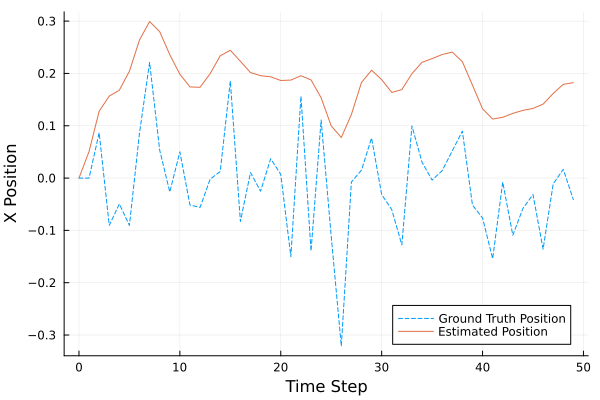

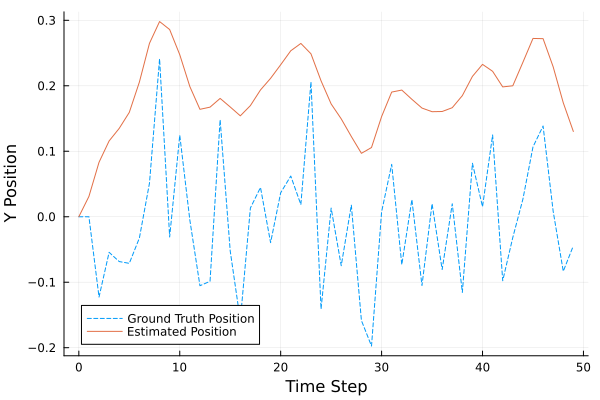

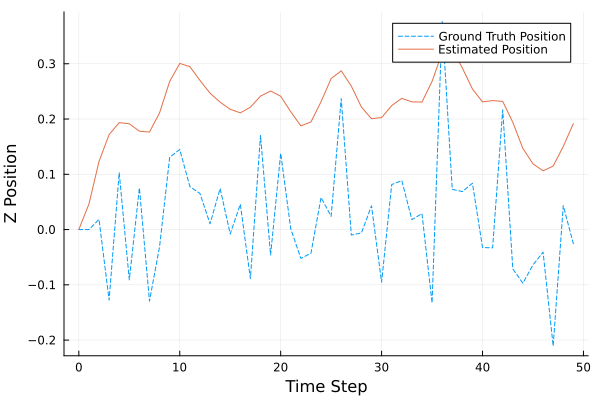

Test Summary:  |
convex trajopt | No tests


Test.DefaultTestSet("convex trajopt", Any[], 0, false, false)

In [37]:
@testset "convex trajopt" begin 
    Random.seed!(1234)
    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    # x0 = [-2;-4;2;0;0;.0]
    x0 = zeros(nx)
    
    # problem size and reference trajectory 
    N = 50
    t_vec = 0:dt:((N-1)*dt)
    u = [randn(N) randn(N) randn(N)] # Random control input
    observ_state_num = 3

    covariance = 0.01 # processing noise
    noise = 0.2
    
    measurement_noise_matrix = fill(noise, (observ_state_num, 1))

    gt = simulate_gt(x0, N, u)
    measurements = simulate_measurements(x0, N, u, measurement_noise_matrix)
    
    # solve Receding Horiozon Estimator  
    X_cvx, U_cvx = RHE(A,B,measurements, x0,N, covariance)
    
    X_sim = [zeros(nx) for i = 1:N]
    X_sim[1] = x0 
    for i = 1:N-1 
        X_sim[i+1] = A*X_sim[i] + B*U_cvx[i]
    end

    
    # -------------plotting---------------------------
    directory = "figure"
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_cvx)
    plots = []
    squared_diffs = []
    axis = ['X', 'Y', 'Z']
    for i in 1:length(gt[1])
        p = plot(t_vec, [m[i] for m in gt], label="Ground Truth Position", xlabel="Time Step", ylabel="$(axis[i]) Position", linestyle=:dash)
        plot!(t_vec, Xm[i,:], label="Estimated Position", linestyle=:solid)
        savefig(p, "$(directory)/RHE_full_state_Plot_$(axis[i]).png")
        push!(plots, p)  # Collect each plot in an array
        append!(squared_diffs, [(gt[j][i] - Xm[i,j])^2 for j in 1:length(t_vec)])
    end

    overall_rmse = sqrt(mean(squared_diffs))
    println("Overall RMSE for noise $noise across all axes: $overall_rmse")
    
    for p in plots
        display(p)
    end
    
    # display(plot(t_vec,Xm[1:3,:]',title = "Positions",
    #              xlabel = "time (s)", ylabel = "position (m)",
    #              label = ["x" "y" "z"]))
    
    # display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
    #         xlabel = "time (s)", ylabel = "velocity (m/s)",
    #              label = ["x" "y" "z"]))
    # display(plot(t_vec[1:end-1],Um',title = "Control",
    #         xlabel = "time (s)", ylabel = "thrust (N)",
    #              label = ["x" "y" "z"]))


end